# Lab 4 - Creating custom tools

## Introduction

In this lab, you will learn how to create custom tools that aid your agents in achieving their goals. We'll also explore working with [OpenStreetMap](https://www.openstreetmap.org/) data. The custom tool we'll develop can provide the distance between two coordinates on a map, which is needed for the practical work.

## What are we going to cover in this notebook?

In this notebook, we will cover the following topics:

1. Utilizing OSMnx
2. Creating custom tools
3. Example of a custom tool

## Using OSMnx

[OSMnx](https://github.com/gboeing/osmnx) is a Python library that includes several functionalities for working on OpenStreetMap data. Let's begin by importing it.

In [1]:
import osmnx as ox

### Downloading a map

The [graph_from_place](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.graph.graph_from_place) function provides an easy way to download the map of a city, just by providing its name. In this case, we'll download the map of Tarragona. We can also specify the network type. Since our practical work use case is focused on roads, we'll specify `drive`.
This library also makes it easy to visualize the map.

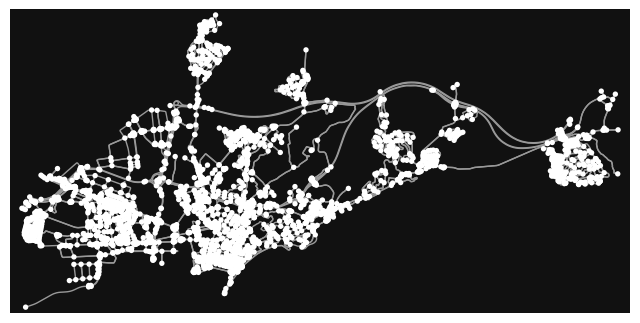

In [2]:
mapp = ox.graph_from_place('Tarragona, Spain', network_type='drive')
fig, ax = ox.plot_graph(mapp)

OSMnx allows us to obtain various [properties](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.stats.basic_stats) of the map.

In [3]:
map_proj = ox.project_graph(mapp)
nodes_proj = ox.graph_to_gdfs(map_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
ox.basic_stats(map_proj, area=graph_area_m, clean_int_tol=15)

{'n': 2771,
 'm': 5396,
 'k_avg': 3.8946228798267772,
 'edge_length_total': 603082.624,
 'edge_length_avg': 111.7647561156412,
 'streets_per_node_avg': 2.905810176831469,
 'streets_per_node_counts': {0: 0, 1: 266, 2: 48, 3: 2150, 4: 298, 5: 6, 6: 3},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.09599422591122339,
  2: 0.01732226632984482,
  3: 0.7758931793576326,
  4: 0.10754240346445326,
  5: 0.0021652832912306026,
  6: 0.0010826416456153013},
 'intersection_count': 2505,
 'street_length_total': 431986.448,
 'street_segment_count': 4015,
 'street_length_avg': 107.59313773349938,
 'circuity_avg': 1.0806396113925256,
 'self_loop_proportion': 0.0012453300124533001,
 'clean_intersection_count': 1420,
 'node_density_km': 42.07809040891524,
 'intersection_density_km': 38.038836692288946,
 'edge_density_km': 9157.90876099525,
 'street_density_km': 6559.785209083421,
 'clean_intersection_density_km': 21.562933374471182}

This map can also be saved as a **graphml** file so it can be loaded later on without having to redownload it.

In [4]:
ox.save_graphml(mapp, filepath='tarragona.graphml')

In [5]:
mapp = ox.load_graphml('tarragona.graphml')

### Compute the distance between two coordinates

Before computing the distances, we'll add the speeds and travel times of all edges (streets) on the map using the following functions: [add_edge_speeds](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.routing.add_edge_speeds) and [add_edge_travel_times](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.routing.add_edge_travel_times). Some areas do not have data on street speeds. In that case, you should provide another parameter `fallback=fallback_speed`.

In [6]:
mapp = ox.routing.add_edge_speeds(mapp)
mapp = ox.routing.add_edge_travel_times(mapp)

Next, we need to find the origin and destination nodes in the graph (map). To do so, we can provide the coordinates of a location, and the [nearest_nodes](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.distance.nearest_nodes) function will find the closest node.

To find the coordinates, we can navigate to [OpenStreetMap](https://www.openstreetmap.org/search?query=Tarragona#map=13/41.12275/1.28111). In this link we have the area of Tarragona. To find the coordinates of a location you can `right click` anywhere on the map, then `Show address`, and the coordinates will appear in the top left corner, in the search bar. **Note** that they are formatted as `Y, X`. In the following example, we've introduced two coordinates of Tarragona.

In [7]:
origin = ox.distance.nearest_nodes(mapp, X=1.238993, Y=41.123784)
destination = ox.distance.nearest_nodes(mapp, X=1.254389, Y=41.120515)

We can compute the [shortest_path](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.routing.shortest_path) between the two nodes. Notice that as weight we're using the total travel time instead of the *length* (total distance). The map and route can also be visualised.

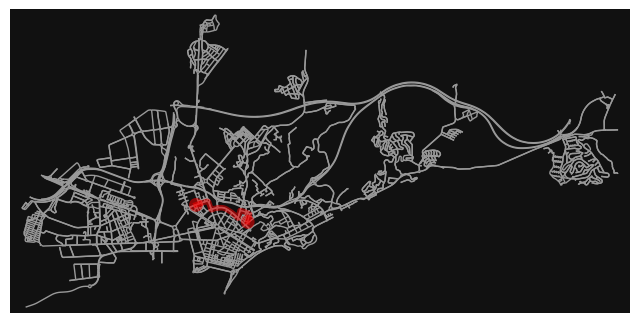

In [8]:
route = ox.shortest_path(mapp, origin, destination, weight='travel_time')
fig, ax = ox.plot_graph_route(mapp, route, node_size=0)

Finally, we can obtain some statistics of that route using [route_to_gdf](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.routing.route_to_gdf). We can see information such as the length or travel time of each street on that route. This information can be used to compute the total length in meters or travel time in seconds.

In [9]:
ox.routing.route_to_gdf(mapp, route).head()

,,,osmid,oneway,lanes,name,highway,reversed,length,geometry,speed_kph,travel_time,ref,junction,maxspeed
u,v,key,,,,,,,,,,,,,
961344525,1041226647,0,229435857,True,2,Carrer del Doctor Mallafré i Guasch,tertiary,False,148.712,"LINESTRING (1.23929 41.12379, 1.23945 41.12383...",50.0,10.7,NaN,NaN,NaN
1041226647,1041225181,0,334895557,True,2,Carrer del Doctor Mallafré i Guasch,tertiary,False,143.359,"LINESTRING (1.24097 41.12422, 1.24113 41.12426...",50.0,10.3,NaN,NaN,NaN
1041225181,332309586,0,645669520,True,2,NaN,trunk,False,25.196,"LINESTRING (1.24261 41.12456, 1.24266 41.12452...",55.3,1.6,N-240,roundabout,NaN
332309586,4560460585,0,30156400,True,NaN,Avinguda d'Andorra,primary,False,188.053,"LINESTRING (1.24287 41.12447, 1.24299 41.12432...",50.0,13.5,N-240,NaN,50
4560460585,332309322,0,574708588,True,NaN,NaN,primary,False,5.075,"LINESTRING (1.24368 41.12289, 1.24366 41.12287...",76.7,0.2,N-240,roundabout,NaN


In [10]:
total_distance = round(sum(ox.routing.route_to_gdf(mapp, route)['length']))
total_distance

1906

In [11]:
total_time = round(sum(ox.routing.route_to_gdf(mapp, route)['travel_time']))
total_time

164

### Exercise

1. Gather a map from another city
2. Save it as a graphml file
3. Find the distance between two coordinates

In [12]:
# Gather map


# Save it as graphml


# Find the distance between two coordinates



In [13]:
# Gather map
mapp = ox.graph_from_place('L\'Espluga de Francolí, Spain', network_type='drive')

# Save it as graphml
ox.save_graphml(mapp, filepath='espluga.graphml')

# Find the distance between two coordinates
mapp = ox.routing.add_edge_speeds(mapp, fallback=30)
mapp = ox.routing.add_edge_travel_times(mapp)

origin = ox.distance.nearest_nodes(mapp, X=1.102592, Y=41.398413)
destination = ox.distance.nearest_nodes(mapp, X=1.097753, Y=41.394530)
route = ox.shortest_path(mapp, origin, destination, weight='travel_time')
total_distance = round(sum(ox.routing.route_to_gdf(mapp, route)['length']))
total_distance

/home/jordi/mambaforge/envs/mas/lib/python3.12/site-packages/osmnx/routing.py:297: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  edges[["highway", "speed_kph"]].set_index("highway").iloc[:, 0].fillna(hwy_speed_avg)


603

## Creating custom tools

As we could see on the previous lab, we can create custom tools for our agents. There are two methods of creating them. Either by subclassing the `BaseTool` class, or using the `@tool` decorator. Using the decorator allows for a simpler method of creating the tools. It's great for simpler tools. In contrast, subclassing `BaseTool` is not as easy, but allows for more complex tools.

In this example, we're going to create a custom tool that is able to load a map and that can be used to compute the distance between two coordinates on that map. We'll assume the user has already obtained a _graphml_ map of the city.

### Tool input schema

Before coding the tool, we'll create a new Pydantic Schema. We'll see in more detail pydantic in the next lab, but TLDR, it will allow us to define the required input for our tool. Similarly to tools, we'll subclass `BaseModel`, and we'll provide the needed arguments and their corresponding description. This will be used by our agents to know how to interact with the tool, so they need to be accurate.

The parameters we'll need are four different floats:
- X origin coordinate
- Y origin coordinate
- X destination coordinate
- Y destination coordinate

In [14]:
from pydantic import BaseModel, Field

class RouteDistanceSchema(BaseModel):
    """Input for the RouteDistanceTool."""
    x_origin: float = Field(..., description='X coordinate of the origin location.')
    y_origin: float = Field(..., description='Y coordinate of the origin location.')
    x_destination: float = Field(..., description='X coordinate of the destination location.')
    y_destination: float = Field(..., description='Y coordinate of the destination location.')

### Route Distance Tool

When creating a custom tool, it's essential to provide an accurate name and description, as the agent will use them to know what the tool does. Moreover, `args_schema` can be used to provide what the schema of the tool inputs will be. In our case, it'll be our `RouteDistanceSchema`.
We also create a `city_map` of type graph, which will hold the city map. By default, it's `None`, as we'll initialize it when the tool is created.

Because `city_map` is based on a custom class provided by the NetworkX library, we need to override the `Config` class and set `arbitrary_types_allowed = True`.

Next, the `__init__` method will initialize the tool by loading the map of the city. A small check is introduced to see if a path to the map is provided. For the sake of simplicity, we'll always load the map when initialized, as all our agents will always be in the same city. Here, the map is loaded as we've seen in the first part of this lab. This tool could also be extended to load the map on runtime.

Finally, the `_run` method is the one that implements the tool's functionality. We first obtain the parameters from the `args`. It's a tuple where the first element is a dictionary with the elements we defined in our schema. So, we can get those values and use OSMnx to compute and return the distance between those two locations. In this case, the computation function is refactored from `_run` into a different function, `_find_distance`.

In [15]:
import networkx

from crewai_tools import BaseTool
from typing import Optional, Type

class RouteDistanceTool(BaseTool):
    name: str = 'Route distance calculator'
    description: str = 'A tool to find the driving route distance between an origin and a destination in a map given their coordinates.'
    args_schema: Type[BaseModel] = RouteDistanceSchema
    city_map: networkx.classes.multidigraph.MultiDiGraph = None
    
    class Config:
        arbitrary_types_allowed = True
    
    def __init__(self, city_map: str, **kwargs):
        super().__init__(**kwargs)
        if not city_map:
            raise Exception('A valid city map path to a graphml file must be provided.')
        self.city_map = ox.load_graphml(city_map)
        self.city_map = ox.routing.add_edge_speeds(self.city_map)
        self.city_map = ox.routing.add_edge_travel_times(self.city_map)
    
    def _run(self, *args, **kwargs) -> int:
        args = args[0]
        x_origin = args.get('x_origin')
        y_origin = args.get('y_origin')
        x_destination = args.get('x_destination')
        y_destination = args.get('y_destination')
        
        return self._find_distance(x_origin, y_origin, x_destination, y_destination)

    def _find_distance(self, x_origin: float, y_origin: float, x_destination: float, y_destination: float) -> int:
        origin_node = ox.distance.nearest_nodes(self.city_map, X=x_origin, Y=y_origin)
        destination_node = ox.distance.nearest_nodes(self.city_map, X=x_destination, Y=y_destination)
        route = ox.shortest_path(self.city_map, origin_node, destination_node, weight='travel_time')
        edge_lengths = ox.routing.route_to_gdf(self.city_map, route)['length']

        return round(sum(edge_lengths))

### Instancing and using the tool

Finally, we can create a new instance of the `RouteDistanceTool` by providing the path to the map.

In [16]:
route_distance = RouteDistanceTool('tarragona.graphml')

To test it, we just need to provide the parameters in a dictionary. We'll use the same coordinates to check that the tool is giving the same output as directly using the OSMnx library.

In [17]:
route_distance.run({'x_origin': 1.238993, 'y_origin': 41.123784, 'x_destination': 1.254389, 'y_destination': 41.120515})

Using Tool: Route distance calculator


1906

## Useful resources

- [CrewAI Docs](https://docs.crewai.com/)
- [CrewAI Repository](https://github.com/crewAIInc/crewAI)
- [Langchain Docs](https://python.langchain.com/v0.2/docs/introduction/)
- [CrewAI Tools](https://docs.crewai.com/core-concepts/Tools/)
- [CrewAI Custom Tools](https://docs.crewai.com/how-to/Create-Custom-Tools/)
- [CrewAI Tools Repository](https://github.com/crewAIInc/crewAI-tools)
- [LangChain Tools](https://python.langchain.com/v0.2/docs/integrations/tools/)
- [OSMnx Docs](https://osmnx.readthedocs.io/en/stable/index.html)